# Imports

In [1]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from datetime import datetime
import pytz

import folding as fold
import plotter as plot

def when():
    now = datetime.now(pytz.timezone("Europe/Rome")).strftime("Day %Y-%m-%d - Time %H:%M:%S\n")
    print(f"\033[1;94m{now}\033[0m")

when()

Day 2024-12-14 - Time 15:20:07



# Load dataset

In [2]:
when()

# data = np.load('/kaggle/input/marsterrain-collage/dataset_collage.npz')
data = np.load('/kaggle/input/marsterrain-pumped/dataset_pumped.npz')

images = data['images'][..., np.newaxis]
labels = data['labels']
num_classes = len(np.unique(data['labels']))

test = np.load('/kaggle/input/marsterrain-original/dataset_original.npz')
test = test['test_set']
test = test[..., np.newaxis]

print(f"Dataset: {images.dtype}{images.shape}, {labels.dtype}{labels.shape}")
print(f"Classes: {num_classes}")

Day 2024-12-14 - Time 15:20:11

Dataset: uint8(14523, 64, 128, 1), uint8(14523, 64, 128)
Classes: 5


# Hyperparameters


In [3]:
when()

model_name = "Gorizia"

batch_size = 32
patience = 50
epochs = 1000
learning_rate = 1e-3
weight_decay = 1e-3
reduce_factor = 0.5

print(f"Model name: {model_name}")
print(f"batch_size: {batch_size}")
print(f"patience: {patience}")
print(f"epochs: {epochs}")
print(f"learning_rate: {learning_rate}")
print(f"weight_decay: {weight_decay}")
print(f"reduce_factor: {reduce_factor}")

Day 2024-12-14 - Time 15:20:37

Model name: Gorizia
batch_size: 32
patience: 50
epochs: 1000
learning_rate: 0.001
weight_decay: 0.001
reduce_factor: 0.5


# Build model

In [4]:
when() 

input_shape = images[0].shape

def conv_block(input_tensor, filters, kernel_size=3, activation='relu', dropout_rate=0.1, name=''):
    x = input_tensor
    x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', kernel_initializer='he_normal', name=name+'conv1')(x)
    x = tfkl.BatchNormalization(name=name+'bn1')(x)
    x = tfkl.Activation(activation, name=name+'act1')(x)
    
    x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', kernel_initializer='he_normal', name=name+'conv2')(x)
    x = tfkl.BatchNormalization(name=name+'bn2')(x)
    x = tfkl.Activation(activation, name=name+'act2')(x)
    
    if dropout_rate > 0:
        x = tfkl.Dropout(dropout_rate, name=name+'dropout')(x)
    
    return x

def attention_gate(x, g, inter_channels):
    theta_x = tfkl.Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(x)
    phi_g = tfkl.Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(g)
    
    concat = tfkl.Add()([theta_x, phi_g])
    relu_concat = tfkl.Activation('relu')(concat)
    
    psi = tfkl.Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')(relu_concat)
    
    return tfkl.Multiply()([x, psi])

# Input layer
input_layer = tfkl.Input(shape=input_shape, name='input_layer')

# Enhanced Downsampling Path
down_block_1 = conv_block(input_layer, 32, name='down_block1_')
d1 = tfkl.MaxPooling2D()(down_block_1)
down_block_2 = conv_block(d1, 64, name='down_block2_')
d2 = tfkl.MaxPooling2D()(down_block_2)

# Bottleneck with Dilated Convolutions
bottleneck = tfkl.Conv2D(128, 3, padding='same', dilation_rate=2, activation='relu')(d2)
bottleneck = tfkl.BatchNormalization()(bottleneck)
bottleneck = tfkl.Conv2D(128, 3, padding='same', dilation_rate=2, activation='relu')(bottleneck)

# Upsampling Path with Attention Gates
u1 = tfkl.UpSampling2D(interpolation='bilinear')(bottleneck)
skip_connection_1 = attention_gate(down_block_2, u1, 64)
u1 = tfkl.Concatenate()([u1, skip_connection_1])
u1 = conv_block(u1, 64, name='up_block1_')

u2 = tfkl.UpSampling2D(interpolation='bilinear')(u1)
skip_connection_2 = attention_gate(down_block_1, u2, 32)
u2 = tfkl.Concatenate()([u2, skip_connection_2])
u2 = conv_block(u2, 32, name='up_block2_')

# Output Layer with additional refinement
output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

# Build model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Enhanced_UNet')

# Show model summary
# model.summary(expand_nested=True, show_trainable=True)

Day 2024-12-14 - Time 15:20:40



# Class weights

In [5]:
when()

class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels.flatten())
print([f"{w:.4f}" for w in class_weights])
class_weights[0] *= 0.01
print([f"{w:.4f}" for w in class_weights])

Day 2024-12-14 - Time 15:20:43

['0.5209', '0.9009', '1.1304', '1.0695', '6.6337']
['0.0052', '0.9009', '1.1304', '1.0695', '6.6337']


# Callbacks

In [6]:
when()

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=reduce_factor,     
    patience=10,        
    min_lr=1e-6,     
    verbose=0   
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='mean_io_u', 
    patience=patience,       
    restore_best_weights=True,
    mode='max',
    verbose=1    
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'{model_name}.keras', 
    monitor='mean_io_u',          
    save_best_only=True,       
    save_weights_only=False,     
    mode='max',
    verbose=0                 
)

class QuietCallback(tf.keras.callbacks.Callback):
    def __init__(self, print_every=10):
        super().__init__()
        self.print_every = print_every

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        
        epochs = self.params['epochs']
        progress = f"\033[1;91mEpoch {epoch+1}/{epochs}{' ' * (len(str(epochs)) - len(str(epoch+1)))}\033[0m   " \
                   f"Accuracy {logs.get('val_accuracy', 0):.4f} - " \
                   f"Loss {logs.get('val_loss', 0):.4f} - " \
                   f"Mean IoU {logs.get('val_mean_io_u', 0):.4f} - " \
                   f"Learning Rate {logs.get('learning_rate', 0):.4e}"
        
        if (epoch+1) % self.print_every == 0:
            print(progress)

Day 2024-12-14 - Time 15:21:00



# Compilation stuff

In [7]:
when()

def focal_loss(class_weights=None, gamma=2.0, alpha=0.25):
    def static_focal_loss(y_true, y_pred, class_weights=class_weights, gamma=gamma, alpha=alpha):
        # Get number of classes from prediction shape
        num_classes = tf.shape(y_pred)[-1]
        
        # Prepare class weights
        if class_weights is None:
            class_weights = tf.ones(num_classes, dtype=tf.float32)
        else:
            class_weights = tf.convert_to_tensor(class_weights, dtype=tf.float32)
        
        # One-hot encode true labels if not already
        y_true_oh = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
        
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        
        # Compute cross entropy
        cross_entropy = -y_true_oh * tf.math.log(y_pred)
        
        # Compute focal weights
        probs = tf.reduce_sum(y_true_oh * y_pred, axis=-1, keepdims=True)
        focal_weights = tf.pow(1 - probs, gamma)
        
        # Apply class weights
        per_class_weights = class_weights * y_true_oh
        
        # Compute focal loss
        focal_loss_per_pixel = tf.reduce_sum(per_class_weights * cross_entropy * focal_weights, axis=-1)
        
        return tf.reduce_mean(focal_loss_per_pixel)
    return static_focal_loss

mean_io_u = tf.keras.metrics.MeanIoU(
    num_classes=num_classes,
    ignore_class=0,
    sparse_y_pred=False,
    name='mean_io_u'
)

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    clipnorm=1.0
)

model.compile(
    loss=focal_loss(class_weights=class_weights),
    optimizer=optimizer,
    metrics=['accuracy', mean_io_u]
)

Day 2024-12-14 - Time 15:21:04



# Train model

In [8]:
when()

tf.keras.backend.clear_session()

# Dataset split
training, validation = fold.split_masked_set(data, shuffle=True, size=0.1, starting=np.random.random())

# Train model epoch
history = model.fit(
    training['images'], training['labels'],
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(validation['images'], validation['labels']),
    callbacks=[reduce_lr, early_stopping, model_checkpoint, QuietCallback()],
    verbose=0
)

print()
when()

# Save model
model_filename = f"{model_name}.keras"
model.save(model_filename)
print(f"Model saved as {model_filename}")

Day 2024-12-14 - Time 15:21:12



I0000 00:00:1734186081.247917      99 service.cc:145] XLA service 0x78b4e40038e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734186081.247980      99 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1734186097.836251      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 10/1000     Accuracy 0.3326 - Loss 1.0583 - Mean IoU 0.2140 - Learning Rate 1.0000e-03
Epoch 20/1000     Accuracy 0.3613 - Loss 1.1144 - Mean IoU 0.3055 - Learning Rate 5.0000e-04
Epoch 30/1000     Accuracy 0.4267 - Loss 1.0691 - Mean IoU 0.3219 - Learning Rate 2.5000e-04
Epoch 40/1000     Accuracy 0.4369 - Loss 1.1797 - Mean IoU 0.3322 - Learning Rate 1.2500e-04
Epoch 50/1000     Accuracy 0.4453 - Loss 1.1587 - Mean IoU 0.3465 - Learning Rate 6.2500e-05
Epoch 60/1000     Accuracy 0.4423 - Loss 1.1879 - Mean IoU 0.3418 - Learning Rate 3.1250e-05
Epoch 70/1000     Accuracy 0.4441 - Loss 1.2005 - Mean IoU 0.3440 - Learning Rate 1.5625e-05
Epoch 80/1000     Accuracy 0.4420 - Loss 1.1985 - Mean IoU 0.3410 - Learning Rate 7.8125e-06
Epoch 90/1000     Accuracy 0.4434 - Loss 1.2030 - Mean IoU 0.3428 - Learning Rate 3.9063e-06
Epoch 100/1000    Accuracy 0.4417 - Loss 1.2032 - Mean IoU 0.3407 - Learning Rate 1.9531e-06
Epoch 110/1000    Accuracy 0.4425 - Loss 1.2049 - Mean IoU 0.3418 - Le

# Plot metrics

Day 2024-12-14 - Time 15:57:06

['accuracy', 'loss', 'mean_io_u', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'learning_rate']


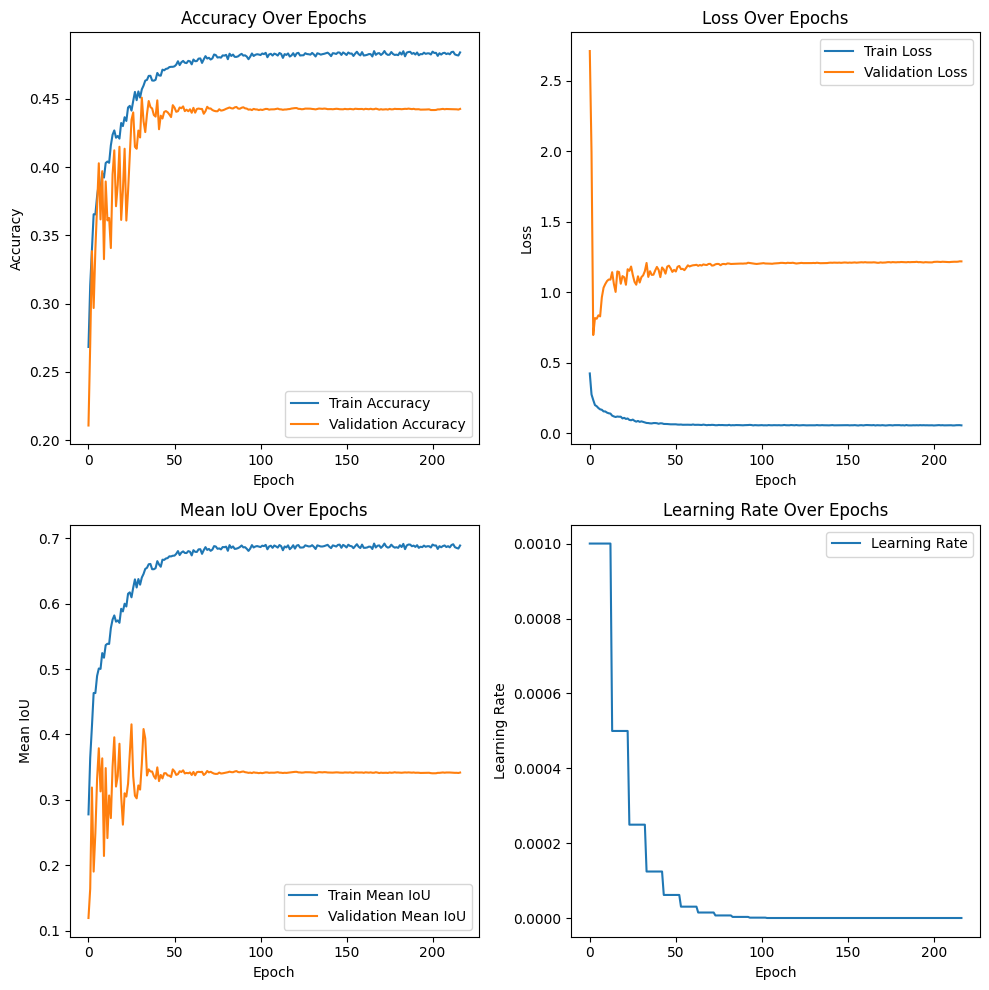

In [10]:
when()

print(list(history.history.keys()))
plt.figure(figsize=(10, 10))

# Accuracy plot
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Mean IoU plot
plt.subplot(2, 2, 3)
plt.plot(history.history['mean_io_u'], label='Train Mean IoU')
plt.plot(history.history['val_mean_io_u'], label='Validation Mean IoU')
plt.title('Mean IoU Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')
plt.legend()

# Learning rate plot
plt.subplot(2, 2, 4)
plt.plot(history.history['learning_rate'], label='Learning Rate')
plt.title('Learning Rate Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

# Prepare submission

In [9]:
when()

predictions = model.predict(test)
predictions = np.argmax(predictions, axis=-1)

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

submission_filename = f"{model_name}.csv"
submission_dataframe = y_to_df(predictions)
submission_dataframe.to_csv(submission_filename, index=False)
print(f"Submission saved as {submission_filename}")

Day 2024-12-14 - Time 15:52:42

314/314 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step
Submission saved as Gorizia.csv


# Plot predictions

Day 2024-12-14 - Time 15:57:36

['0.0052', '0.9009', '1.1304', '1.0695', '6.6337']
['0.0005', '0.3656', '0.3543', '0.2748', '0.0048']


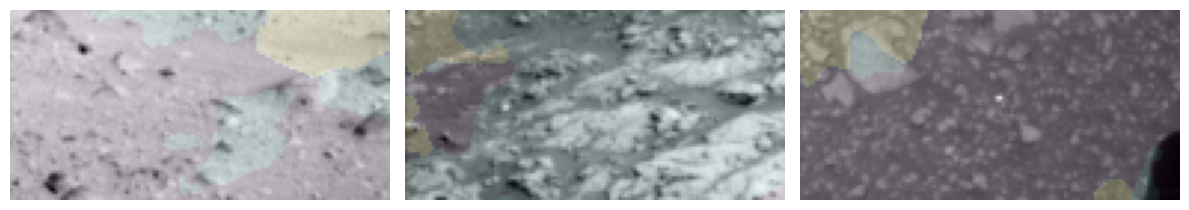

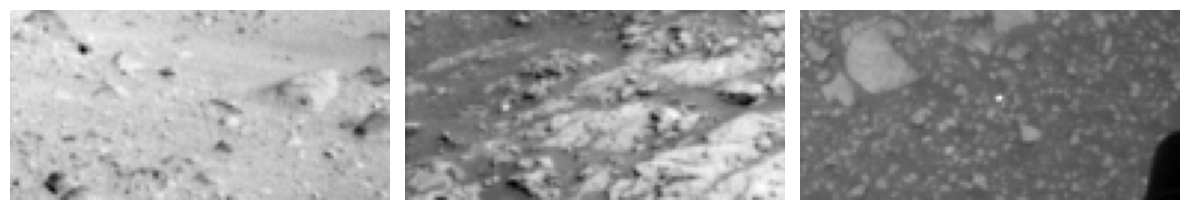

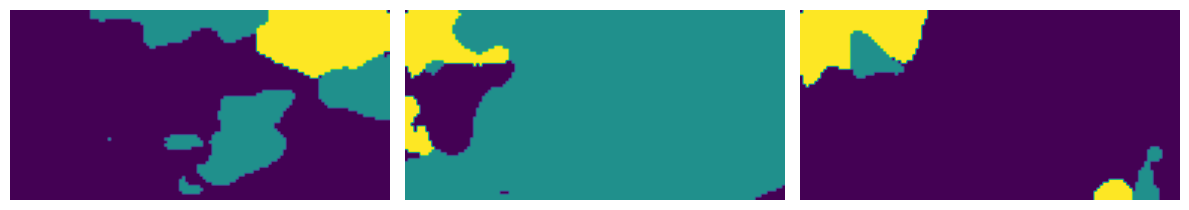

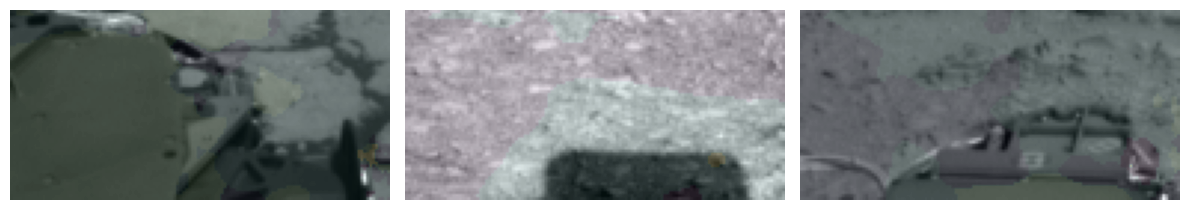

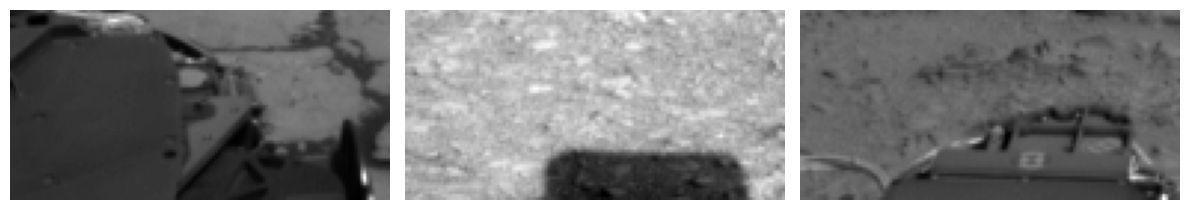

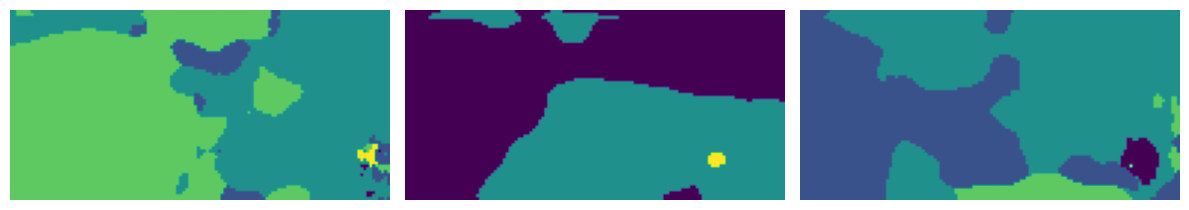

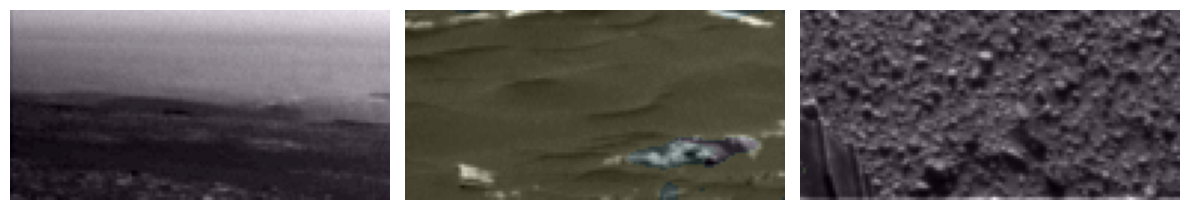

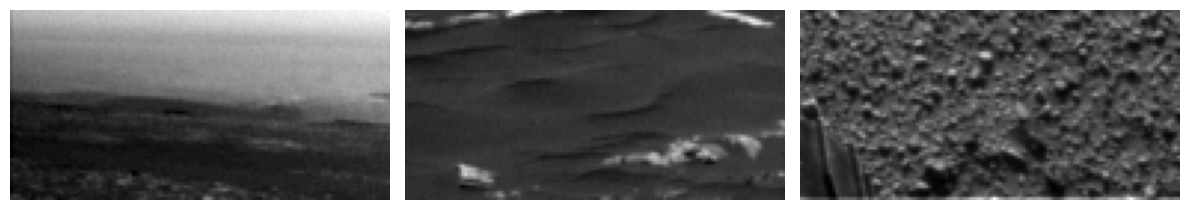

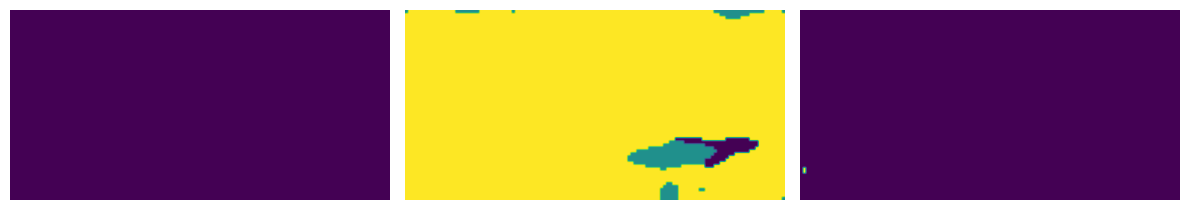

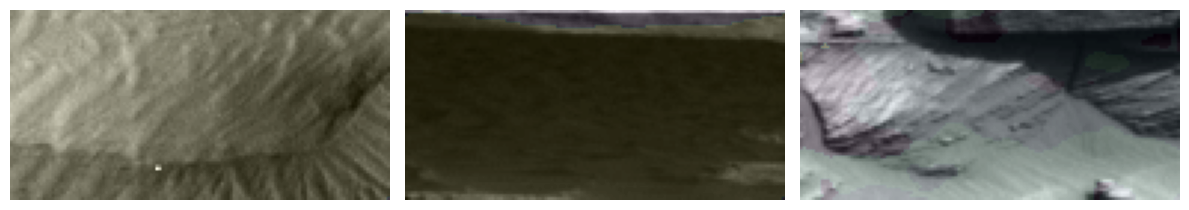

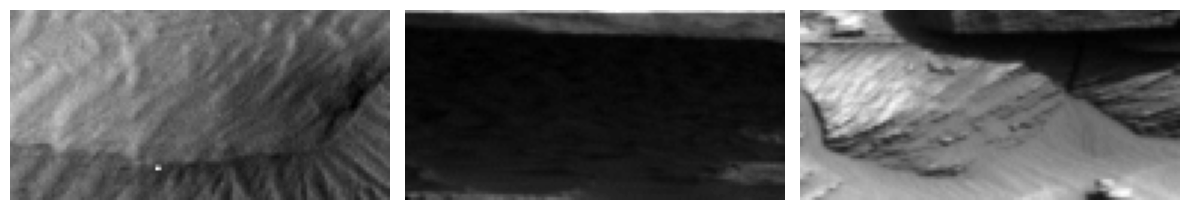

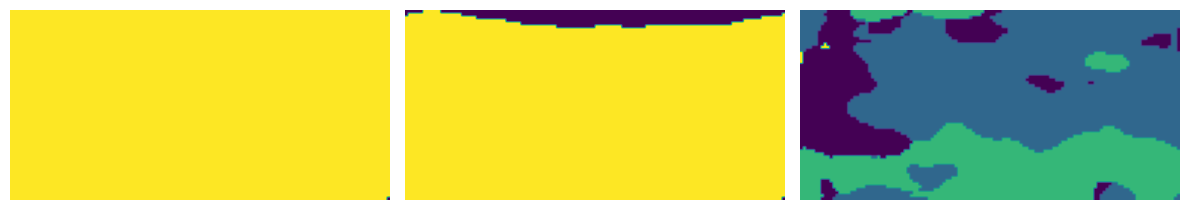

In [12]:
when()

def random_plot():
    i = random.randint(0, len(predictions)-1)
    j = random.randint(0, len(predictions)-1)
    k = random.randint(0, len(predictions)-1)
    plot.plot_masked_image(        
        (test.squeeze()[i], predictions[i]),
        (test.squeeze()[j], predictions[j]),
        (test.squeeze()[k], predictions[k]),
        mask_alpha=0.1)
    plot.plot_masked_image(        
        (test.squeeze()[i], predictions[i]),
        (test.squeeze()[j], predictions[j]),
        (test.squeeze()[k], predictions[k]),
        mask_alpha=0)
    plot.plot_masked_image(        
        (test.squeeze()[i], predictions[i]),
        (test.squeeze()[j], predictions[j]),
        (test.squeeze()[k], predictions[k]),
        mask_alpha=1)

print([f"{w:.4f}" for w in class_weights])
counts = np.bincount(predictions.flatten())
rates = counts / np.sum(counts)
print([f"{r:.4f}" for r in rates])
for _ in range(4):
    random_plot()
    print()